In [1]:
from PIL import Image, ImageDraw
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import heapq
from bitarray import bitarray
%matplotlib inline

In [2]:
# sep = "\\"  # вариант для Windows
sep = "/"  # вариат для Linux

Данный проект посвящён написанию и анализу работы такого алгоритма как JPS (Jump Poin Search). Здесь рассматриваются как
базовая реализация алгоритма JPS (почитать о ней можно тут: `http://grastien.net/ban/articles/hg-aaai11.pdf`), так и его модификация с помощью блоков (Block-based Symmetry Breaking) (почитать об этом можно тут: `https://harabor.net/data/papers/harabor-grastien-icaps14.pdf`). В коде далее есть небольшое количество комментариев, которые
могут прояснить непонятные моменты.

Также в данном проекте проводится сравнение написанных алгоритмов с базовым алгоритмом A*.

Задачи для тестирования взяты отсюда: `https://movingai.com/benchmarks/grids.html`. 

В данной лабораторной у нас будет три карты (как и обычно, каждая карта - это некотрое прямоугольное поле из клеток, каждая клетка - либо свободна и в ней можно находиться, либо она занята препятствием) и для каждой карты будет по 100 задач (различной сложности! - эти задачи мы выбираем равномерно из сценариев для каждой из трёх карт (карты и сценарии к ним находятся по ссылке, показанной ранее)), которые тестируемые варианты алгоритма A* должны решить (каждая задача состоит из начальной клетки, из которой начинаем движение и конечной, в которую нам нужно найти кратчайший путь). Все карты предполагаются 8-связными (то есть из каждой клетки можно походить (если такой ход возможен) влево, вправо, вверх, вниз и 4 хода по диагонали). Ход в какую-то клетку возможен, если эта клетка не занята препятствием; также заметим, что в данной реализации мы предполагаем, что **можно срезать углы**.

Итак, для начала посмотрим на карты, которые выбраны для тестирования:


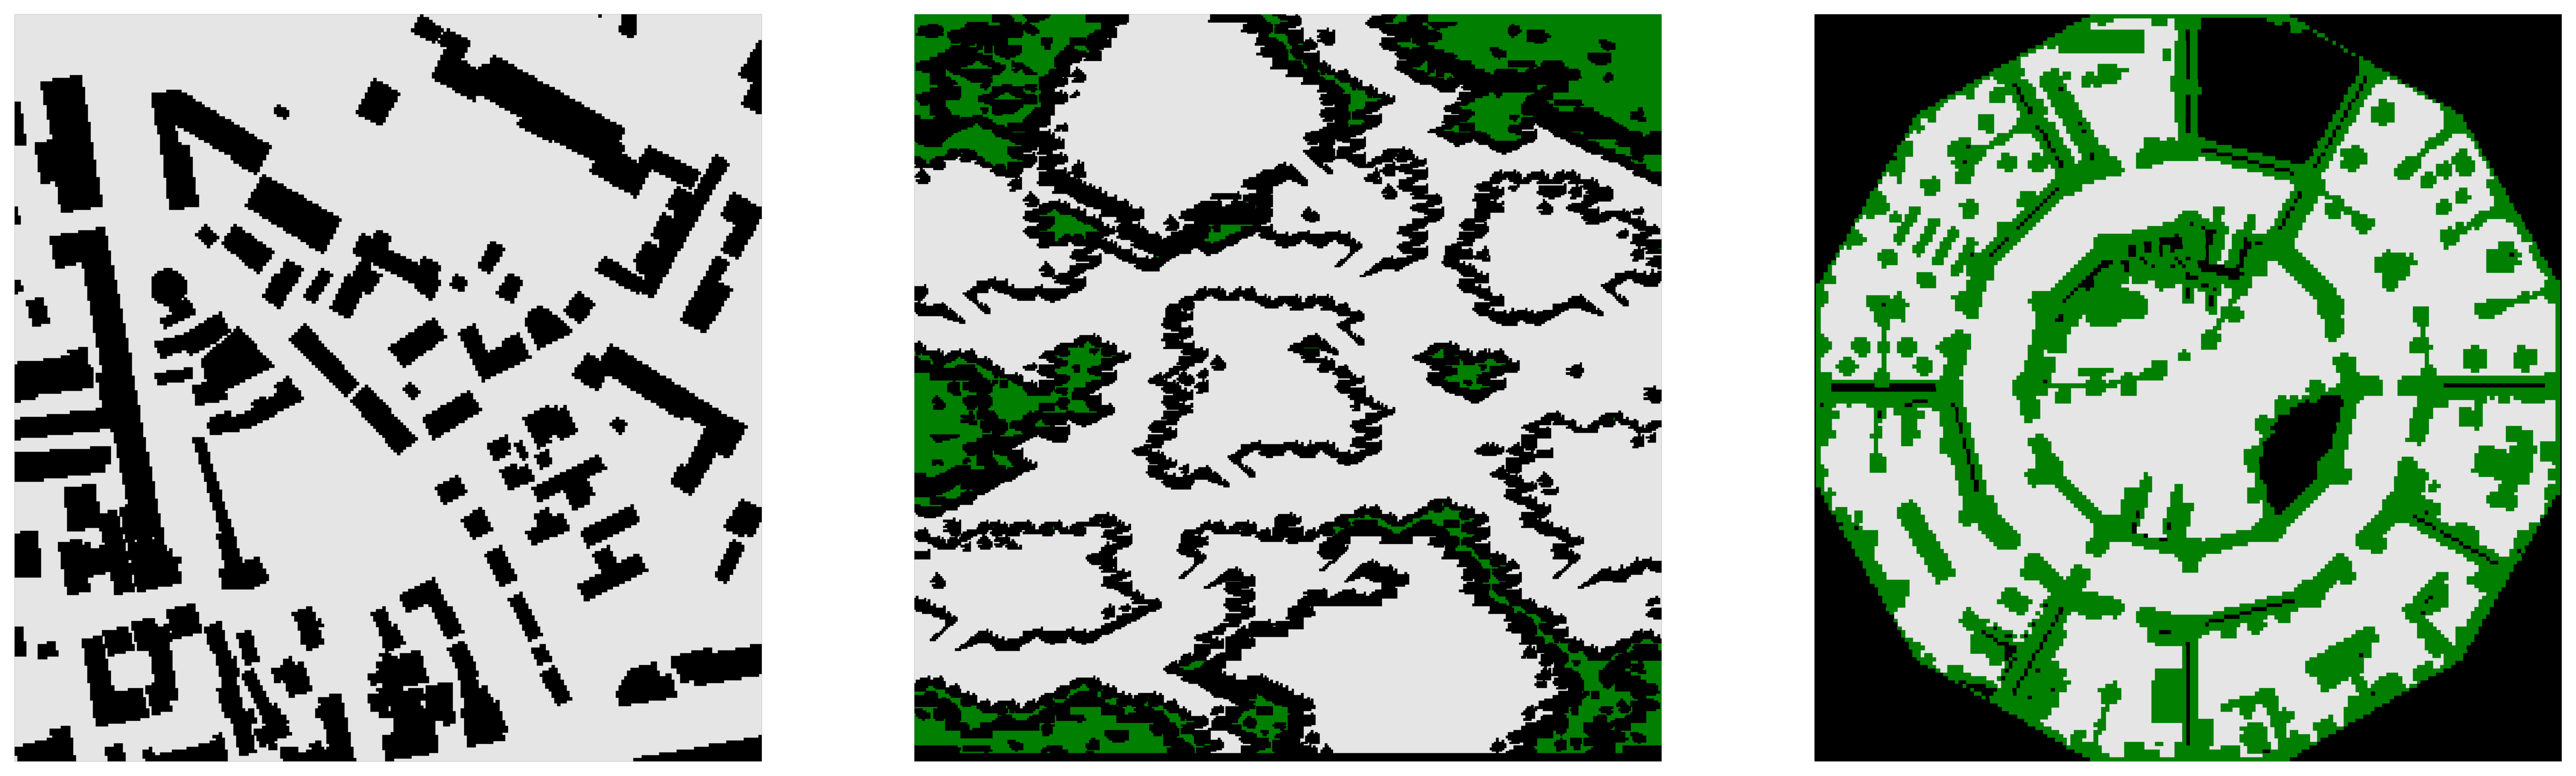

In [3]:
_, ax = plt.subplots(nrows=1, ncols=3, figsize=(25, 15), dpi=400)
ax[0].imshow(mpimg.imread(sep.join(["Москва", "Moscow_1_256.png"])))
ax[1].imshow(mpimg.imread(sep.join(["IceFloes из Starcraft", "IceFloes.png"])))
ax[2].imshow(mpimg.imread(sep.join(["lac304d из Dragon Age Origins", "lak304d.png"])))
for i in range(3): ax[i].axis("off")
plt.show()

Первая карта - городская - а именно, это карта части города Москва. Вторая карта - это карта IceFloes из игры Starcraft, она
интресна формой препятствий, которые образуют области, внутри которых можно находиться, но, чтобы их них выбраться, необходимо
найти выход из препятствий, которые как ограда окружают область. Третья карта - карта lac304d из игры Dragon Age: Origins, её 
форма напоминает круговой лабиринт - и чтобы дойти, например, от границы этого круга к его центру, нужно преодолеть множество
препятствий, образующих кольца вокруг центра.

Как можно заметить, все карты имеют совершенно разную топологию, благодаря чему наши тесты будут более объективными, а также
будут полезны не только для сравнения алгоритмов между собой, но и для сравнения эффективности одного алгоритма на разных картах.

В качестве вариантов алгоритма, которые мы будем тестировать, у нас будет обычный JPS, JPS с блоками и A* без перераскрытий (все алгоритмы c диагональной эвристикой). Для JPS с блоками мы рассмотрим 4 различных длин блока: 16, 32, 64, 128.

То есть всего у нас три набора по 100 задач для каждого из 6 вариантов алгоритма (4 штуки JPS с блоками, обычный JPS и один A*).

#### Далее код проекта:

In [4]:
def compute_cost(i1, j1, i2, j2):
    if abs(i1 - i2) + abs(j1 - j2) == 1: # если кардинальный ход, то его тоимость 1
        return 1
    elif abs(i1 - i2) + abs(j1 - j2) == 2:  # если диагональный ход, то его стоимость sqrt(2) - длина диагонли
        return math.sqrt(2)
    else:
        raise Exception('Поптыка посчитать стоимость недоступного хода. Возможны лишь кардинальные и диагональные ходы')

In [407]:
class Map:

    """=========================обычная часть класса Map, как и в предыдущих алгоритмах======================="""
    def __init__(self):
        '''
        Default constructor
        '''

        self._width = 0
        self._height = 0
        self._cells = None
    
        
    def read_from_string(self, cell_str, width, height):
        '''
        Converting a string (with '#' representing obstacles and '.' representing free cells) to a grid
        '''
        self._width = width
        self._height = height
        self._cells = np.zeros((height, width), dtype="int")
        cell_lines = cell_str.split("\n")
        i = 0
        j = 0
        for l in cell_lines:
            if len(l) != 0:
                j = 0
                for c in l:
                    if c in ['.', 'G']:
                        self._cells[i][j] = 0
                    elif c in ['#', '@', 'O', 'T', 'S', 'W']:
                        self._cells[i][j] = 1
                    else:
                        continue
                    j += 1
                if j != width:
                    raise Exception("Size Error. Map width = ", j, ", but must be", width )
                
                i += 1

        if i != height:
            raise Exception("Size Error. Map height = ", i, ", but must be", height )
    
     
    def set_grid_cells(self, width, height, grid_cells):
        '''
        Initialization of map by list of cells.
        '''
        self._width = width
        self._height = height
        self._cells = np.array(grid_cells, dtype="int")


    def in_bounds(self, i, j):
        '''
        Check if the cell is on a grid.
        '''
        return (0 <= j < self._width) and (0 <= i < self._height)
    

    def traversable(self, i, j):
        '''
        Check if the cell is not an obstacle.
        '''
        return not self._cells[i][j]

    def get_neighbors(self, i, j):  # обычная функция получени соседей
        neighbors = []
        delta = [[0, 1], [1, 0], [0, -1], [-1, 0], [1, 1], [1, -1], [-1, 1], [-1, -1]]
        for d in delta:
            if self.in_bounds(i + d[0], j + d[1]) and self.traversable(i + d[0], j + d[1]):
                neighbors.append((i + d[0], j + d[1]))
        return neighbors
    
    def get_size(self):
        return (self._height, self._width)
    
    
    """=========================часть класса, отвечающая за общую реализацию JPS:======================="""
    def get_direction(self, X, Y):  # получаем направление, по которому из X попадаем в Y
        res = [Y[0] - X[0], Y[1] - X[1]]
        direction = list(np.sign(res).astype(int))  # нормируем, чтобы направление было типо (1, -1), (1, 0) и тд
        assert(direction in [[0, 1], [1, 0], [0, -1], [-1, 0], [1, 1], [1, -1], [-1, 1], [-1, -1]])
        return direction
    
    def good(self, i, j):
        return self.in_bounds(i, j) and self.traversable(i, j)
    
    def wall(self, i, j):
        return self.in_bounds(i, j) and not self.traversable(i, j)
    
    def pruning_neighbors(self, i, j, direction):  # функция, которая возвращает обрезанные (prunning) соседи вершины (i,j), если мы пришли в неё по направлению direction
        p_neighbors = []
        forced_exist = False
        delta_hv = [[0, 1], [1, 0], [0, -1], [-1, 0]]
        delta_d = [[1, 1], [1, -1], [-1, 1], [-1, -1]]
        
        x, y = direction[0], direction[1]
        if direction in delta_hv:
            if self.good(i + x, j + y):
                p_neighbors.append([i + x, j + y])

            orto = [[i + y, j + x],
                    [i - y, j - x]]
            orto_and_move = [[orto[0][0] + x, orto[0][1] + y],
                             [orto[1][0] + x, orto[1][1] + y]]
            for i in range(2):
                if self.wall(orto[i][0], orto[i][1]) and self.good(orto_and_move[i][0], orto_and_move[i][1]):
                    p_neighbors.append(orto_and_move[i])
                    forced_exist = True
            
        elif direction in delta_d:
            if self.good(i + x, j + y):
                p_neighbors.append([i + x, j + y])
            if self.good(i, j + y):
                p_neighbors.append([i, j + y])
            if self.good(i + x, j):
                p_neighbors.append([i + x, j])
            
            if self.wall(i, j - y) and self.good(i + x, j - y):
                p_neighbors.append([i + x, j - y])
                forced_exist = True

            if self.wall(i - x, j) and self.good(i - x, j + y):
                p_neighbors.append([i - x, j + y])
                forced_exist = True

        else:
            raise Exception('Wrong direction in pruning')
        if [i, j] in p_neighbors:
            p_neighbors.remove([i, j])
        assert(len(p_neighbors)<=8)
        return p_neighbors, forced_exist
    
    
    """=========================часть класса, отвечающая за дефолтную (без улучшений) реализацию JPS:======================="""
    def jump(self, current, direction, start, goal, additional_cost):
        x, y = direction[0], direction[1]
        n = [current[0] + x, current[1] + y]
        
        if not (self.in_bounds(n[0], n[1]) and self.traversable(n[0], n[1])):
            return None
        if n == goal:
            return n, additional_cost
        if self.pruning_neighbors(n[0], n[1], direction)[1]:
            return n, additional_cost
        delta_d = [[1, 1], [1, -1], [-1, 1], [-1, -1]]
        if direction in delta_d:
            if self.jump(n, [0, y], start, goal, additional_cost + compute_cost(current[0], current[1], n[0], n[1])):
                return n, additional_cost
            if self.jump(n, [x, 0], start, goal, additional_cost + compute_cost(current[0], current[1], n[0], n[1])):
                return n, additional_cost 
        return self.jump(n, direction, start, goal, additional_cost + compute_cost(current[0], current[1], n[0], n[1]))

    def DEFAULT_identify_successors(self, current, parent, start, goal):
        successors = []
        if parent:
            direction = self.get_direction(parent, current)
            neighbors = self.pruning_neighbors(current[0], current[1], direction)[0]
        else:
            neighbors = self.get_neighbors(current[0], current[1])
            
        for n in neighbors:
            successor = self.jump(current,[n[0] - current[0], n[1] - current[1]], start, goal, compute_cost(current[0], current[1], n[0], n[1]))
            if successor and not (successor in successors):
                successors.append(successor)
        return successors
    
    
    """=========================часть класса, отвечающая за реализацию JPS с BLOCK-улучшением:======================="""
    def get_byte(self, i, j, direction, block_size):  # получаем блок битов от точки (i, j) в направлении direction (бит 1 - препятствие, бит 0 - свободно)
        def only_greater_zero(a):
            if a > 0:
                return a
            else:
                return 0
            
        byte = np.ones(block_size, dtype="int")
        
        if direction == [0, 1]:  # вправо
            if 0 <= i < self._height:
                part = self._cells[i, j:j+block_size]
                byte[:len(part)] = part
        elif direction == [0, -1]:  # влево
            if 0 <= i < self._height:
                part = self._cells[i, only_greater_zero(j-block_size+1):j+1]
                byte[:len(part)] = part[::-1]
        elif direction == [1, 0]:  # вниз
            if 0 <= j < self._width:
                part = self._cells[i:i+block_size, j]
                byte[:len(part)] = part
        elif direction == [-1, 0]: # вверх
            if 0 <= j < self._width:
                part = self._cells[only_greater_zero(i-block_size+1):i+1, j]
                byte[:len(part)] = part[::-1]
        else:
            raise Exception("Некорректное направление для получения массива битов")
        return bitarray(list(byte))
    
    def forced(self, B):
        ans = (B >> 1) & ~B
        return ans
    
    def get_BS(self, B_up, B_down, B_N):
        return self.forced(B_up) | self.forced(B_down) #| B_N - ОТЛИЧИЕ ОТ СТАТЬИ: тут мы не добавляем BN, а проверяем его отдельно, так как мы можем срезать углы - и удобнее BN (это фактически просто блок с препятствиями на пути) рассматривать отдельно
    
    def ffs(self, B):  # получаем первую слева единичку в бинарной строке B
        if 1 not in B:
            return np.inf
        return B.index(bitarray('1'))
    
    def is_between(self, x, a, b):  # проверить, что x \in [a, b]
        return (x - a) * (x - b) <= 0
       
    def block_jump(self, P, N, start, goal, block_size=32, diag=False):  # с помощью блоков быстро ищем (в направлении от P к N) точки, у которых есть forced-сосед (или точку, которая goal) (если от P к N мы идем по диагонали, то мы ищем эти точки и по вертикали и по горизонтали в направлениях, которые получаются, если диагональный вектор направления от P к N разложить по вертикали и горизонтали)
        N_succesors = []
        
        PN_direction = self.get_direction(P, N)                      
        directions = [[0, PN_direction[1]], [PN_direction[0], 0]] 
        for d in directions:  # для каждого направления
            if d[0] == d[1] == 0: continue  
            i, j = N
            
            if diag: 
                flag=True
            else:
                flag=False
            while True:
                if d[0] == 0:  # рассматриваем горизонтальные блоки
                    Bup = self.get_byte(i-1, j, d, block_size)
                    BN = self.get_byte(i, j, d, block_size)
                    Bdown = self.get_byte(i+1, j, d, block_size)
                if d[1] == 0:  # вертикально
                    Bup = self.get_byte(i, j-1, d, block_size)
                    BN = self.get_byte(i, j, d, block_size)
                    Bdown = self.get_byte(i, j+1, d, block_size)
                if flag:
                    Bup[0] = 0
                    Bdown[0] = 0
                    flag=False
                BS = self.get_BS(Bup, Bdown, BN)

                if 1 in (BS | BN):  # если нашёлся установленный бит в блоке BS (то есть есть вершина с forced соседом) или в блоке BN (есть препятствие)
                    break
                else:  # если нет, сдвигаем наши блоки (а точнее координату начала) на длину блока - 1
                    if d[0] == 0:
                        j = j + d[1] * (block_size - 1)  # горизонтальный блок
                    if d[1] == 0:
                        i = i + d[0] * (block_size - 1)  # вертикальный блок

            bs = self.ffs(BS)  # первый бит BS = место, у которого есть forced сосед
            bn = self.ffs(BN)  # первый бит BN = место, где есть препятствие на пути из рассматриваемой нами вершины N 
            assert(bn > 0 and bs > 0)
            
            if d[0] == 0:          
                if goal[0] == N[0] and self.is_between(goal[1], N[1],  j + d[1] * (min(bs, bn) - 1)):  # проверяем, не перепрыгнули ли мы нашим блоком через целевую вершину - если что, добавляем её как successor
                    N_succesors.append([goal[0], goal[1]])
                elif bs <= bn:  # если нет, то проверяем, что место с forced-соседом, не позже препятствия (ОТЛИЧИЕ ОТ СТАТЬИ: тут мы ещё равентсво добавляем, так как мы можем срезать углы)
                    N_succesors.append([i, j + d[1] * (bs - 1)])
            if d[1] == 0:                   
                if goal[1] == N[1] and self.is_between(goal[0], N[0],  i + d[0] * (min(bs, bn) - 1)):
                    N_succesors.append([goal[0], goal[1]])
                elif bs <= bn:
                    N_succesors.append([i + d[0] * (bs - 1), j])
                
        return N_succesors  # возвращаем список succesor (или jump-points правильно?), которые нашли 
    
    def get_successor_instead_N(self, P, N, start, goal, block_size):  # мы тут переходим от точки P к её соседу - к N - вместо N хотим получить другую вершину-последователя P (вроде бы одну, но на всяких случай массив создаем), которая будет подальше, а значит быстрее работать будет      
        if (P[0] == N[0]) or (P[1] == N[1]):  # если ход от P к N горизонтальный или вертикальный, то просто просматриваем блок в этом направлении в поисках последователя
            successors = self.block_jump(P=P, N=N, start=start, block_size=block_size, goal=goal)
        else:
            successors = []   
            PN_direction = self.get_direction(P, N)
            assert(abs(PN_direction[0]) + abs(PN_direction[1]) == 2)  # проверяем что по диагонали идем
            
            prev_diagonal = P
            current_diagonal = N
            while True:  # далее от предыдущей точки к следующей идем по диагонали (в направлении от P к N) 
                if self.pruning_neighbors(current_diagonal[0], current_diagonal[1], PN_direction)[1]:  # если текущая точка на диагонали имеет forced-соседа, то выходим
                    successors.append(current_diagonal)
                    break              
                elif self.block_jump(P=prev_diagonal, N=current_diagonal, start=start, goal=goal, block_size=block_size, diag=True):  # если у текущей точки на диагонали есть последователь, который расположен на одном из лучей, выпущенных от этой точки под 45 градусов к диагонали (короче диагональ разложили по вертикальной оси и горизональной оси в тех же направлениях, что мы движимся по диагонали), то тоже останавливаемся - в нашем случае это значит, что не пустой массив возвращает block_jump
                    successors.append(current_diagonal)                                                              # если идем по диагонали, то мы можем ошибочно принять саму точку N в block_jump за имеющую forced соседа (потому что там мы смотри когда идем по прямой, но когда идем по диагонали, то forced по-другому могут выглядть)-> чтобы не добавлять лишних successor, передаем параметр diag
                    break
                else:  # в ином случае мы еще останавливаемся, если наткнулись на целевую вершину
                    if current_diagonal == goal:
                        successors.append(current_diagonal)
                        break
                
                prev_diagonal = current_diagonal
                current_diagonal = [current_diagonal[0] + PN_direction[0],
                                    current_diagonal[1] + PN_direction[1]]  # смещаемся далее по диагонали    
                
                if (not self.in_bounds(*current_diagonal)) or (not self.traversable(*current_diagonal)):
                    break  # если наткнулись на препятствие, то выходим
        return successors
    
    def several_compute_costs(self, a, array):  # считаем стоимость перехода от точки a до каждой точки массива array
        res = []
        for p in array:
            assert (a[0] == p[0] or a[1] == p[1] or abs(a[0] - p[0]) == abs(a[0] - p[0]))  # проверяем, что точка a и p лежат на одной линии (вертикаль,  горизонталь или диагональ - иначе непонятно, как стоимость считать)
            res.append(np.sqrt((a[0] - p[0]) ** 2 + (a[1] - p[1]) ** 2))
        return res
                
    def BLOCK_identify_successors(self, current, parent, start, goal, block_size):  # для точки current, в которую мы пришли из точки parent, считаем последователей (в смысле те jump-точки, которые будем рассматривать) <- используем улучшение с блоками для этого
        all_successors = []
        if parent:  # если предыдущая вершина не None, то получаем соседей после обрезания (pruning)
            direction = self.get_direction(parent, current)
            assert(direction in [[0, 1], [1, 0], [0, -1], [-1, 0], [1, 1], [1, -1], [-1, 1], [-1, -1]])
            neighbors = self.pruning_neighbors(current[0], current[1], direction)[0]
        else:  # если предыдущей вершины нет (например, current - это стартовая вершина), то получаем в качестве соседей все седение клетки
            neighbors = self.get_neighbors(current[0], current[1])
                
        for n in neighbors:  # далее для каждого соседа получаем последователя (то есть мы заменяем соседа n на более далекого (чтобы быстрее работал), но как доказывается в алгоритме, как бы эквивалентного последователя - то есть мы ничего не теряем в оптимальности и работоспособности)
            successor_for_n = self.get_successor_instead_N(P=current, N=n, start=start, goal=goal, block_size=block_size)
            all_successors += successor_for_n
        
        all_costs = self.several_compute_costs(current, all_successors)
        return all_successors, all_costs

In [408]:
class Node:  # обычный класс, как и в других алгоритмах поиска
    '''
    Node class represents a search node

    - i, j: coordinates of corresponding grid element
    - g: g-value of the node
    - h: h-value of the node // always 0 for Dijkstra
    - F: f-value of the node // always equal to g-value for Dijkstra
    - parent: pointer to the parent-node 

    '''
    

    def __init__(self, i, j, g = 0, h = 0, f = None, parent = None, tie_breaking_func = None):
        self.i = i
        self.j = j
        self.g = g
        self.h = h
        if f is None:
            self.f = self.g + h
        else:
            self.f = f        
        self.parent = parent

        
    
    def __eq__(self, other):
        '''
        Estimating where the two search nodes are the same,
        which is needed to detect dublicates in the search tree.
        '''
        return (self.i == other.i) and (self.j == other.j)
    
    def __hash__(self):
        '''
        To implement CLOSED as set of nodes we need Node to be hashable.
        '''
        ij = self.i, self.j
        return hash(ij)


    def __lt__(self, other): 
        '''
        Comparing the keys (i.e. the f-values) of two nodes,
        which is needed to sort/extract the best element from OPEN.
        
        This comparator is very basic. We will code a more plausible comparator further on.
        '''
        return self.f < other.f

In [409]:
class SearchTreePQS:
    
    def __init__(self):
        self._open = []      
        self._closed = set()      
        self._enc_open_dublicates = 0
        
    def __len__(self):
        return len(self._open) + len(self._closed)
                    
    def open_is_empty(self):
        return len(self._open) == 0
     
    def add_to_open(self, item):  
        heapq.heappush(self._open, item)
        return
    
    def get_best_node_from_open(self):
        best = None
        while(True):
            best = heapq.heappop(self._open)  
            if (not self.was_expanded(best)): break
            if len(self._open) == 0: return None
        return best    

    def add_to_closed(self, item):
        self._closed.add(item)

    def was_expanded(self, item):
        return item in self._closed

    @property
    def OPEN(self):
        return self._open
    
    @property
    def CLOSED(self):
        return self._closed

    @property
    def number_of_open_dublicates(self):
        return self._enc_open_dublicates

Далее определяем функцию диагональной метрики, для которой будем тестировать алгоритмы:

In [410]:
def octile_distance(i1, j1, i2, j2):  # Диагональная метрика
    delta_x = abs(i1 - i2)
    delta_y = abs(j1 - j2)
    return math.sqrt(2) * min(delta_x, delta_y) + abs(delta_x - delta_y)

Далее обычный алгоритм A*:

In [411]:
def astar(grid_map, start_i, start_j, goal_i, goal_j, heuristic_func = None, search_tree = None):
    '''
    TODO
    '''
    ast = search_tree()
    steps = 0
    nodes_created = 0
    CLOSED = None

    start = Node(start_i, start_j, f = 0, h=heuristic_func(start_i, start_j, goal_i, goal_j))
    nodes_created += 1 
    ast.add_to_open(start)
        
    while (not ast.open_is_empty()):
        steps += 1
        
        curr_node = ast.get_best_node_from_open() 
        if curr_node is None: break
        ast.add_to_closed(curr_node)
        
        if ((curr_node.i == goal_i) and (curr_node.j == goal_j)):
            OPEN = ast.OPEN
            CLOSED = ast.CLOSED
            return (True, curr_node, steps, nodes_created, OPEN, CLOSED)
        
        for i, j in grid_map.get_neighbors(curr_node.i, curr_node.j):  
            transfer_cost = compute_cost(i1=curr_node.i, j1=curr_node.j, i2=i, j2=j) 
            succesor = Node(i=i, j=j, g=curr_node.g + transfer_cost, parent = curr_node, h=heuristic_func(i, j, goal_i, goal_j))
            nodes_created += 1
            
            if (not ast.was_expanded(item=succesor)):  
                ast.add_to_open(succesor)   

    CLOSED = ast.CLOSED
    return False, None, steps, nodes_created, None, CLOSED

Код алгоритма JPS:

In [412]:
def JPS(grid_map, start_i, start_j, goal_i, goal_j, heuristic_func = None, search_tree = None, BLOCK_param=None):
    
    def get_coords(node):
        if node:
            return [node.i, node.j]
        else:
            return None
        
    ast = search_tree()
    steps = 0
    nodes_created = 0
    CLOSED = None

    start = Node(start_i, start_j, 0, 0, heuristic_func(start_i, start_j, goal_i, goal_j))
    goal = Node(goal_i, goal_j, 0, 0)
    ast.add_to_open(start)
    current = None
    
    while not ast.open_is_empty():
        steps += 1
        
        curr_node = ast.get_best_node_from_open() 
        if curr_node is None: break
        ast.add_to_closed(curr_node)
        
        if ((curr_node.i == goal_i) and (curr_node.j == goal_j)):
            OPEN = ast.OPEN
            CLOSED = ast.CLOSED
            return (True, curr_node, steps, nodes_created, OPEN, CLOSED)
        
        if BLOCK_param:
            succ_coords, succ_costs = grid_map.BLOCK_identify_successors(get_coords(curr_node), 
                                                                         get_coords(curr_node.parent), 
                                                                         [start_i, start_j], [goal_i, goal_j],
                                                                         block_size=BLOCK_param)
            iterate_succ = zip(succ_coords, succ_costs)
        else:
            iterate_succ = grid_map.DEFAULT_identify_successors(get_coords(curr_node), 
                                                                get_coords(curr_node.parent), 
                                                                [start_i, start_j], [goal_i, goal_j])
           
        for coord, cost in iterate_succ:
            i, j = coord
            succesor = Node(i, j, curr_node.g + cost, heuristic_func(i, j,  goal_i, goal_j), parent=curr_node)
            nodes_created += 1
            if not ast.was_expanded(succesor):
                ast.add_to_open(succesor) 
        ast.add_to_closed(curr_node)
        steps += 1
        
    CLOSED = ast.CLOSED
    return False, None, steps, nodes_created, None, CLOSED

Функции для чтения карты и сценариев:

In [413]:
def read_map_from_file(path):  # читаем карту из файла и возвращаем эту карту в виде объекста нашего класса Map
    map_file = open(path)
    _ = map_file.readline()
    height = int(map_file.readline().split()[1])
    width = int(map_file.readline().split()[1])
    _ = map_file.readline()
    cells = [[0 for _ in range(width)] for _ in range(height)]
    
    i = 0
    j = 0
    for line in map_file:
        j = 0
        for symbol in line:
            if symbol == '.' or symbol == 'G':
                cells[i][j] = 0
            else:
                cells[i][j] = 1
                
            j += 1
            if j == width: break
                
        i += 1
        if i == height: break
            
    map_file.close()
    read_map = Map()
    read_map.set_grid_cells(width, height, cells)
   
    return read_map

In [414]:
def read_scenarios_from_file(path, need_scenes):  # из файла равномерно читаем need_scenes сценариев
    scen_file = open(path)
    _ = scen_file.readline()
    
    scenarios = []
    for line in scen_file:
        columns = line.split("\t")[-5:]
        scenarios.append(list(map(int, columns[:-1])) + [float(columns[-1])])
    scen_file.close()
    
    num_all_scenes = len(scenarios)
    if num_all_scenes <= need_scenes: 
        complete_scenes = scenarios
    elif need_scenes == 1:
        complete_scenes = [scenarios[0]]
    else:
        step = (num_all_scenes - 1) / (need_scenes - 1)
        complete_scenes = []
        for i in range(need_scenes):
            complete_scenes.append(scenarios[round(step * i)])
            
    return complete_scenes
    

Вводим предварительные данные для тестирования

In [459]:
n = 100  # число сценариев для каждой карты
eps = 1e-5  # число, на сколько могут отличаться float значения, чтобы мы считали их равными (это для сравнений длин кратчайших путей)

In [460]:
# Три карты и по n=100 сценариев для каждой из них
num_maps = 3  # число карт

moscow_map = read_map_from_file(sep.join(["Москва", "Moscow_1_256.map"]))  # считываем карту
moscow_scenes = read_scenarios_from_file(sep.join(["Москва", "Moscow_1_256.map.scen"]), n)  # и n сценариев к ней

icefloes_map = read_map_from_file(sep.join(["IceFloes из Starcraft", "IceFloes.map"]))
icefloes_scenes = read_scenarios_from_file(sep.join(["IceFloes из Starcraft", "IceFloes.map.scen"]), n)

dragon_map = read_map_from_file(sep.join(["lac304d из Dragon Age Origins", "lak304d.map"]))
dragon_scenes = read_scenarios_from_file(sep.join(["lac304d из Dragon Age Origins", "lak304d.map.scen"]), n)

tests_map = [moscow_map, icefloes_map, dragon_map]  # собираем все в массив
tests_scene = [moscow_scenes, icefloes_scenes, dragon_scenes]

In [461]:
"""
Для каждого из 6 алгоритмов заводим по два
массива: steps и time. Оба массива в свою очередь содержат массивы для с результатами для каждой из карт.

В массиве steps хранится количество шагов алгоритма, которые он сделал для нахождения пути, а в массиве time хранится
время работы алгоритма.

Каждый массив steps хранит num_maps массивов для каждой карты, и в каждом таком массиве хранится n (число сценариев) чисел
- количетсв шагов алгоритма на каждом из n сценариев для данной карты. Для time аналогично. Таким образом, мы храним
данные для всех трех карт по отдельности.
"""

JPS_steps = [[] for _ in range(num_maps)]
JPS_block_16_steps = [[] for _ in range(num_maps)]
JPS_block_32_steps = [[] for _ in range(num_maps)]
JPS_block_64_steps = [[] for _ in range(num_maps)]
JPS_block_128_steps = [[] for _ in range(num_maps)]
A_steps = [[] for _ in range(num_maps)]

JPS_time = [[] for _ in range(num_maps)]
JPS_block_16_time = [[] for _ in range(num_maps)]
JPS_block_32_time = [[] for _ in range(num_maps)]
JPS_block_64_time = [[] for _ in range(num_maps)]
JPS_block_128_time = [[] for _ in range(num_maps)]
A_time = [[] for _ in range(num_maps)]

In [462]:
# собираем всё для каждой метрики в массив  
all_steps = [JPS_steps, JPS_block_16_steps, JPS_block_32_steps, JPS_block_64_steps, JPS_block_128_steps, A_steps]
all_time = [JPS_time, JPS_block_16_time, JPS_block_32_time, JPS_block_64_time, JPS_block_128_time, A_time]
# устанавливаем параметры (None - это обычный JPS, число - длина блока, "A" - это A*)
algorithms = [None, 16, 32, 64, 128, "A"]

In [463]:
all_true_length = [[] for _ in range(num_maps)]

Для начала с помощью A* вычислим правильные длины наикратчайших путей (алгоритм A* был протестирован множество раз и в его правильности сомнений нет):

In [464]:
for test_map, test_scene, true_length, num_map in zip(tests_map, tests_scene, all_true_length, range(num_maps)):
    for scene in test_scene:
        start_j = scene[0]  # ВАЖНО!!! у нас i - это координата по выосте (те номер строки), а j - координата по горизонтали!
        start_i = scene[1]  # а в сценарии первой идёт координата x (координата по горизонтали), а потом y (по вертикали)
        goal_j = scene[2]  # поэтому читаем только так! - сначала j координата (start_j), затем i (start_i)
        goal_i = scene[3]  # на этом была долго ошибка, которую сложно было найти...

        find_path, last_node, num_steps, _, _, _ = astar(test_map, start_i, start_j, goal_i, 
                                                         goal_j, heuristic_func=octile_distance, 
                                                         search_tree=SearchTreePQS)
        
        if find_path:
            length_find_path = last_node.g
            true_length_of_path = length_find_path
            true_length.append(true_length_of_path)
        else:
            raise Exception("Что-то не так") 

In [465]:
all_true_length

[[3.82842712474619,
  5.656854249492381,
  9.65685424949238,
  14.313708498984763,
  19.142135623730955,
  21,
  24.142135623730955,
  31.82842712474619,
  32.627416997969526,
  41.31370849898476,
  47.284271247461874,
  50.041630560342604,
  55.11269837220807,
  58.254833995939,
  60.14213562373094,
  64.8700576850888,
  68.2132034355964,
  74.49747468305827,
  80.05382386916229,
  84.15432893255064,
  87.8406204335659,
  94.84062043356592,
  96.45584412271569,
  101.71067811865467,
  106.11269837220804,
  108.32590180780441,
  109.53910524340083,
  121.0832611206852,
  121.28427124746185,
  129.22539674441606,
  131.66904755831206,
  138.0954544295049,
  142.22539674441617,
  144.840620433566,
  149.74011537017765,
  155.94112549695421,
  163.3969696196701,
  165.58073580374355,
  171.63961030678928,
  173.17871555019028,
  178.52691193458116,
  179.58073580374375,
  184.81118318204335,
  190.1959594928934,
  195.9533188057742,
  200.7645019878173,
  200.32085117392157,
  207.7523086

Наконец начинаем тестировать:

In [466]:
for steps, timers, param in zip(all_steps, all_time, algorithms):
    for test_map, test_scene, num_map in zip(tests_map, tests_scene, range(num_maps)):
        for scene, true_length_of_path in zip(test_scene, all_true_length[num_map]):
            start_j = scene[0]  # ВАЖНО!!! у нас i - это координата по выосте (те номер строки), а j - координата по горизонтали!
            start_i = scene[1]  # а в сценарии первой идёт координата x (координата по горизонтали), а потом y (по вертикали)
            goal_j = scene[2]  # поэтому читаем только так! - сначала j координата (start_j), затем i (start_i)
            goal_i = scene[3]  # на этом была долго ошибка, которую сложно было найти...
            
            begin_time = time.time()
            
            if param == "A":
                find_path, last_node, num_steps, _, _, _ = astar(test_map, start_i, start_j, goal_i, 
                                                                 goal_j, heuristic_func=octile_distance, 
                                                                 search_tree=SearchTreePQS)
            else:
                find_path, last_node, num_steps, _, _, _ = JPS(grid_map=test_map, 
                                                               start_i=start_i, start_j=start_j,
                                                               goal_i=goal_i, goal_j=goal_j, 
                                                               heuristic_func=octile_distance, 
                                                               search_tree=SearchTreePQS,
                                                               BLOCK_param=param) 
               

            time_for_algorithm = time.time() - begin_time
            
            if find_path:  # если путь алгоритм нашёл
                length_find_path = last_node.g
                if abs(length_find_path - true_length_of_path) > eps:
                    print(num_map, scene, param)
                    raise Exception("Ошибка! Неверно найден путь")

                steps[num_map].append(num_steps)
                timers[num_map].append(time_for_algorithm)
            else:
                raise Exception("Что-то не так")  # если путь не нашли, то выдаём исключение, ведь во всех наших тестах путь точно есть 

Теперь отобразим результаты в симпатичном виде

In [472]:
# но для начала для удобства все наши массивы переделаем в numpy

JPS_steps = np.array(JPS_steps)
JPS_block_16_steps = np.array(JPS_block_16_steps)
JPS_block_32_steps = np.array(JPS_block_32_steps)
JPS_block_64_steps = np.array(JPS_block_64_steps)
JPS_block_128_steps = np.array(JPS_block_128_steps)
A_steps = np.array(A_steps)

JPS_time = np.array(JPS_time)
JPS_block_16_time = np.array(JPS_block_16_time)
JPS_block_32_time = np.array(JPS_block_32_time)
JPS_block_64_time = np.array(JPS_block_64_time)
JPS_block_128_time = np.array(JPS_block_128_time)
A_time = np.array(A_time)

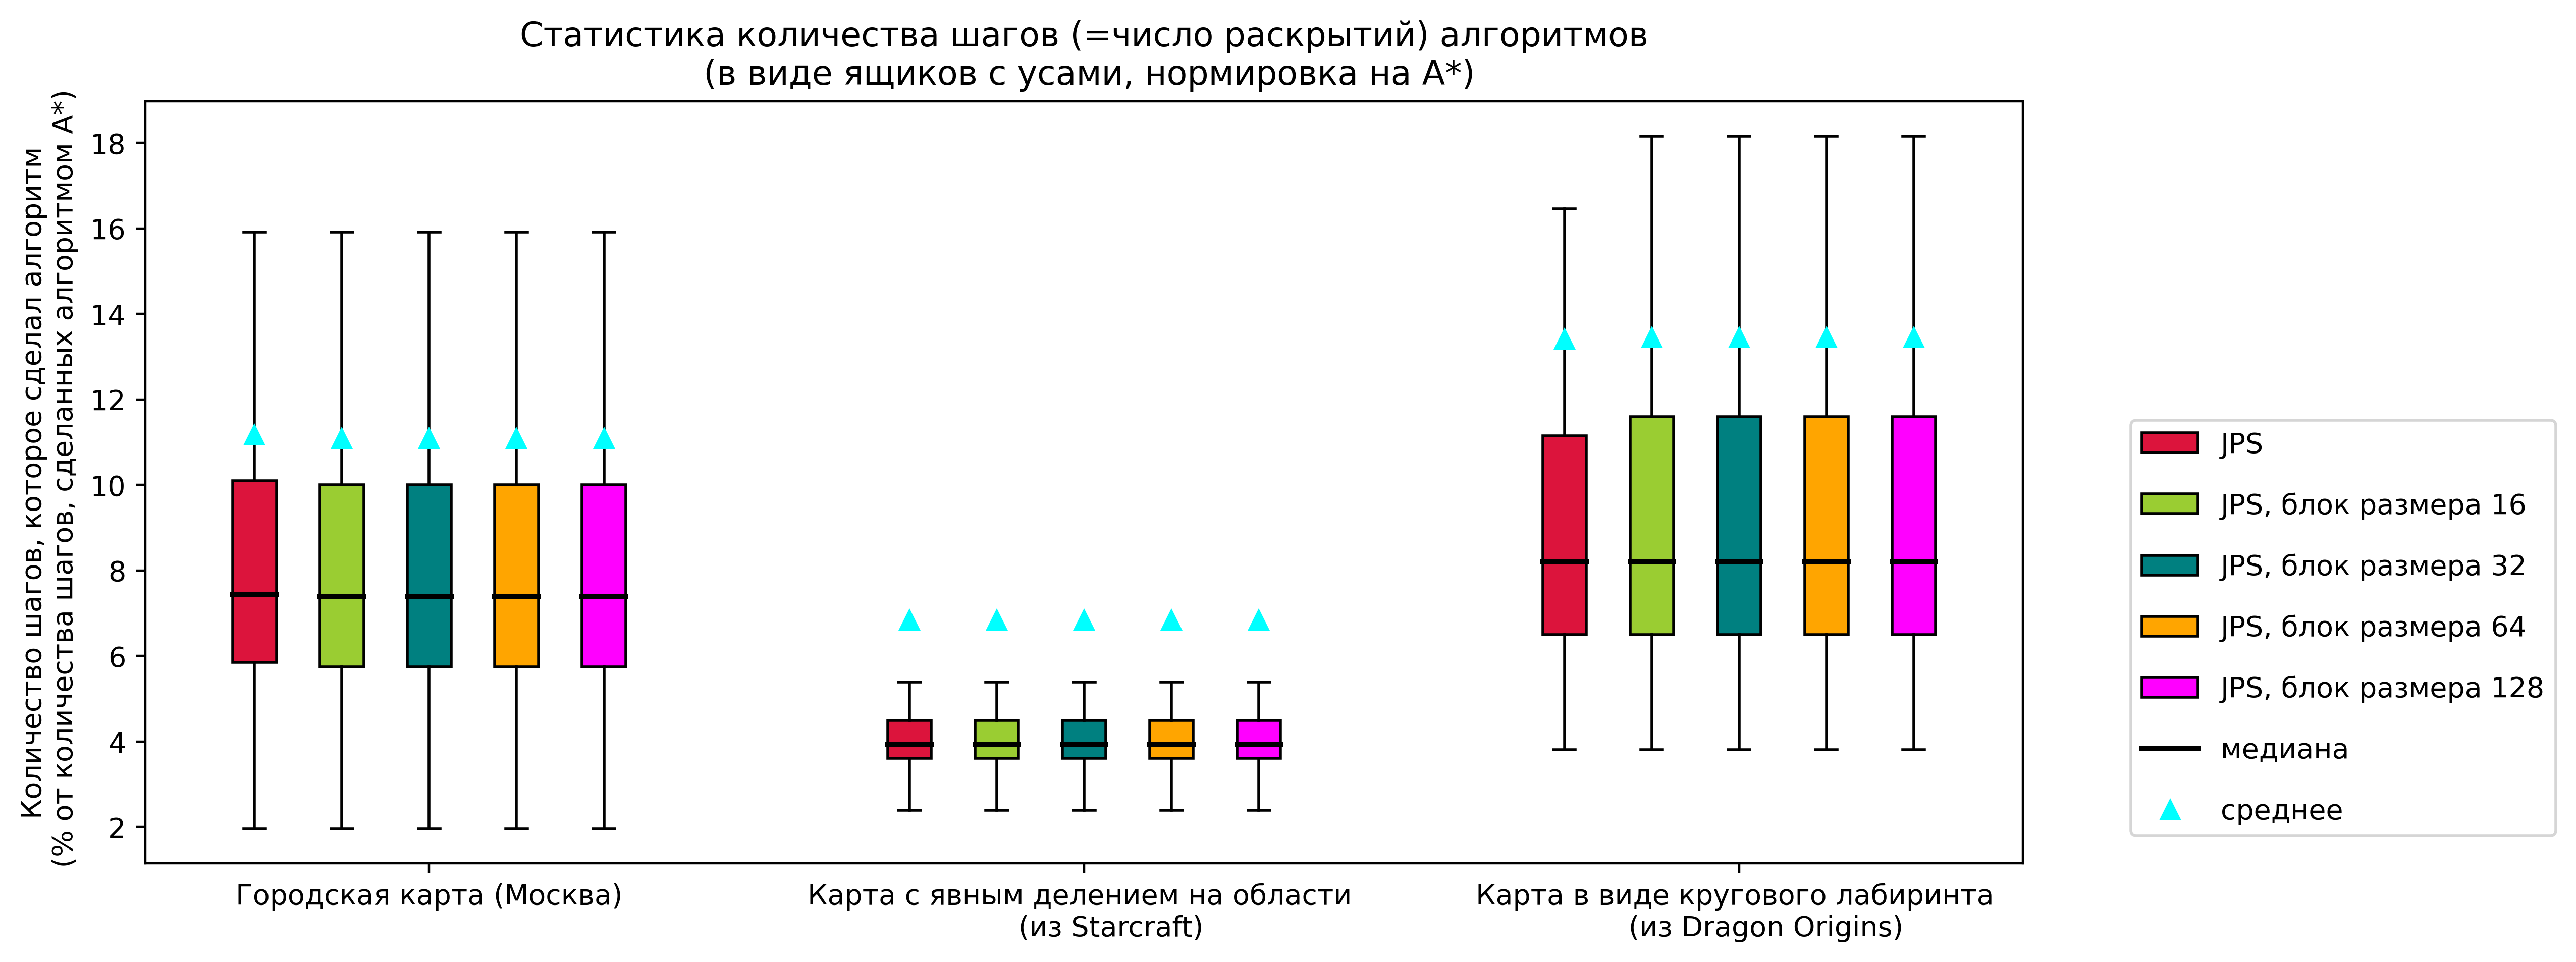

In [477]:
_, ax = plt.subplots(figsize=(12, 5), dpi=400)
ax.set_title("Статистика количества шагов (=число раскрытий) алгоритмов\n (в виде ящиков с усами, нормировка на A*)")
ax.set_ylabel("Количество шагов, которое сделал алгоритм\n (% от количества шагов, сделанных алгоритмом A*)")

shift = 0.4  # сдвиг
index = 3 * np.arange(3)  # положение трех ящиков на оси x (мы 5 раз рисуем по три ящика в каждом из boxes_i - вот в кажом boxes_i положения этих трёх ящиков задаются index)

boxes1 = plt.boxplot((JPS_steps[0] / A_steps[0] * 100, 
                      JPS_steps[1] / A_steps[1] * 100, 
                      JPS_steps[2] / A_steps[2] * 100), 
            showmeans=True, patch_artist=True, boxprops=dict(facecolor="crimson"),
            widths=shift / 2, positions=index, showfliers=False,
            medianprops=dict(linewidth=1.8, color="black"),
            meanprops=dict(markeredgewidth=0, markerfacecolor="cyan", markersize=8))

boxes2 = plt.boxplot((JPS_block_16_steps[0] / A_steps[0] * 100, 
                      JPS_block_16_steps[1] / A_steps[1] * 100, 
                      JPS_block_16_steps[2] / A_steps[2] * 100), 
            showmeans=True, patch_artist=True, boxprops=dict(facecolor="yellowgreen"),
            widths=shift / 2, positions=index + 1 * shift, showfliers=False,
            medianprops=dict(linewidth=1.8, color="black"),
            meanprops=dict(markeredgewidth=0, markerfacecolor="cyan", markersize=8))

boxes3 = plt.boxplot((JPS_block_32_steps[0] / A_steps[0] * 100, 
                      JPS_block_32_steps[1] / A_steps[1] * 100, 
                      JPS_block_32_steps[2] / A_steps[2] * 100), 
            showmeans=True, patch_artist=True, boxprops=dict(facecolor="teal"),
            widths=shift / 2, positions=index + 2 * shift, showfliers=False,
            medianprops=dict(linewidth=1.8, color="black"),
            meanprops=dict(markeredgewidth=0, markerfacecolor="cyan", markersize=8))

boxes4 = plt.boxplot((JPS_block_64_steps[0] / A_steps[0] * 100, 
                      JPS_block_64_steps[1] / A_steps[1] * 100, 
                      JPS_block_64_steps[2] / A_steps[2] * 100), 
            showmeans=True, patch_artist=True, boxprops=dict(facecolor="orange"),
            widths=shift / 2, positions=index + 3 * shift, showfliers=False,
            medianprops=dict(linewidth=1.8, color="black"),
            meanprops=dict(markeredgewidth=0, markerfacecolor="cyan", markersize=8))

boxes5 = plt.boxplot((JPS_block_128_steps[0] / A_steps[0] * 100, 
                      JPS_block_128_steps[1] / A_steps[1] * 100, 
                      JPS_block_128_steps[2] / A_steps[2] * 100), 
            showmeans=True, patch_artist=True, boxprops=dict(facecolor="magenta"),
            widths=shift / 2, positions=index + 4 * shift, showfliers=False,
            medianprops=dict(linewidth=1.8, color="black"),
            meanprops=dict(markeredgewidth=0, markerfacecolor="cyan", markersize=8))


plt.xticks(index + 2 * shift, ["Городская карта (Москва)", "Карта с явным делением на области \n      (из Starcraft)",
                           "Карта в виде кругового лабиринта \n      (из Dragon Origins)"])
plt.legend([boxes1["boxes"][0], boxes2["boxes"][0], boxes3["boxes"][0], boxes4["boxes"][0], boxes5["boxes"][0],
            boxes1["medians"][0], boxes1["means"][0]],
           ["JPS", "JPS, блок размера " + str(16), "JPS, блок размера " + str(32),
            "JPS, блок размера " + str(64), "JPS, блок размера " + str(128), "медиана", "среднее"],
            bbox_to_anchor = (1.05, 0.6), labelspacing=1.2)
#plt.savefig("boxplot_steps.png", transparent=False, bbox_inches="tight", facecolor='white')  # сохраняем всю картинку (transparent=False - чтобы фон самой диаграммы не был прозрачен, facecolor='white' - чтобы фон, где надписи был белым а не тусклым, bbox_inches="tight" - чтобы сохранялось все то, что выводится (а не обрезанный кусок))
plt.show()

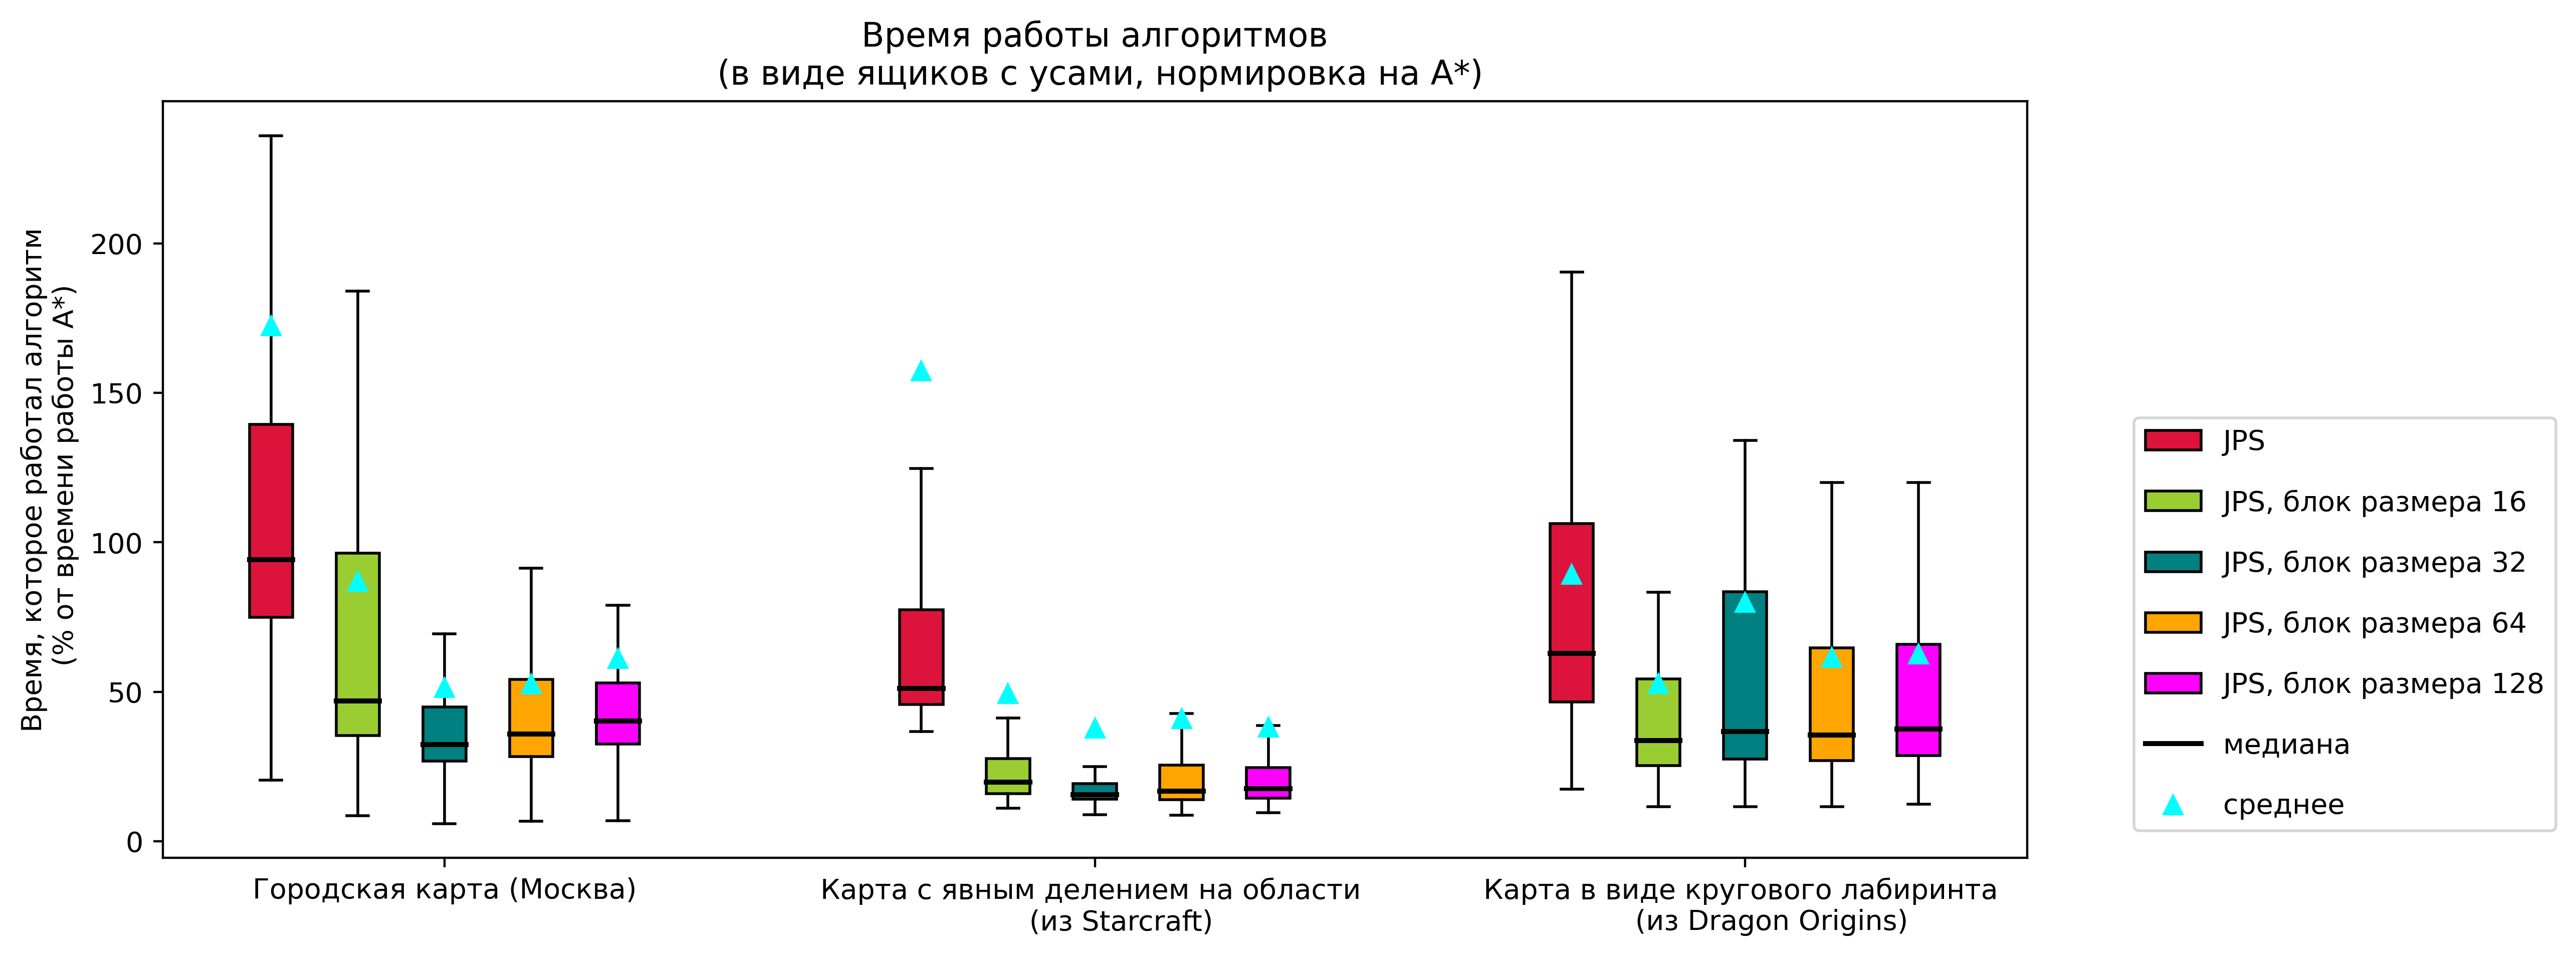

In [480]:
_, ax = plt.subplots(figsize=(12, 5), dpi=400)
ax.set_title("Время работы алгоритмов\n (в виде ящиков с усами, нормировка на A*)")
ax.set_ylabel("Время, которое работал алгоритм\n (% от времени работы A*)")

shift = 0.4  # сдвиг
index = 3 * np.arange(3)  # положение трех ящиков на оси x (мы 5 раз рисуем по три ящика в каждом из boxes_i - вот в кажом boxes_i положения этих трёх ящиков задаются index)

def ind_gt_zero(array):
    return array > eps

ind0 = ind_gt_zero(A_time[0])
ind1 = ind_gt_zero(A_time[1])
ind2 = ind_gt_zero(A_time[2])

boxes1 = plt.boxplot((JPS_time[0][ind0] / A_time[0][ind0] * 100, 
                      JPS_time[1][ind1] / A_time[1][ind1] * 100, 
                      JPS_time[2][ind2] / A_time[2][ind2] * 100), 
            showmeans=True, patch_artist=True, boxprops=dict(facecolor="crimson"),
            widths=shift / 2, positions=index, showfliers=False,
            medianprops=dict(linewidth=1.8, color="black"),
            meanprops=dict(markeredgewidth=0, markerfacecolor="cyan", markersize=8))

boxes2 = plt.boxplot((JPS_block_16_time[0][ind0] / A_time[0][ind0] * 100, 
                      JPS_block_16_time[1][ind1] / A_time[1][ind1] * 100, 
                      JPS_block_16_time[2][ind2] / A_time[2][ind2] * 100), 
            showmeans=True, patch_artist=True, boxprops=dict(facecolor="yellowgreen"),
            widths=shift / 2, positions=index + 1 * shift, showfliers=False,
            medianprops=dict(linewidth=1.8, color="black"),
            meanprops=dict(markeredgewidth=0, markerfacecolor="cyan", markersize=8))

boxes3 = plt.boxplot((JPS_block_32_time[0][ind0] / A_time[0][ind0] * 100, 
                      JPS_block_32_time[1][ind1] / A_time[1][ind1] * 100, 
                      JPS_block_32_time[2][ind2] / A_time[2][ind2] * 100), 
            showmeans=True, patch_artist=True, boxprops=dict(facecolor="teal"),
            widths=shift / 2, positions=index + 2 * shift, showfliers=False,
            medianprops=dict(linewidth=1.8, color="black"),
            meanprops=dict(markeredgewidth=0, markerfacecolor="cyan", markersize=8))

boxes4 = plt.boxplot((JPS_block_64_time[0][ind0] / A_time[0][ind0] * 100, 
                      JPS_block_64_time[1][ind1] / A_time[1][ind1] * 100, 
                      JPS_block_64_time[2][ind2] / A_time[2][ind2] * 100), 
            showmeans=True, patch_artist=True, boxprops=dict(facecolor="orange"),
            widths=shift / 2, positions=index + 3 * shift, showfliers=False,
            medianprops=dict(linewidth=1.8, color="black"),
            meanprops=dict(markeredgewidth=0, markerfacecolor="cyan", markersize=8))

boxes5 = plt.boxplot((JPS_block_128_time[0][ind0] / A_time[0][ind0] * 100, 
                      JPS_block_128_time[1][ind1] / A_time[1][ind1] * 100, 
                      JPS_block_128_time[2][ind2] / A_time[2][ind2] * 100), 
            showmeans=True, patch_artist=True, boxprops=dict(facecolor="magenta"),
            widths=shift / 2, positions=index + 4 * shift, showfliers=False,
            medianprops=dict(linewidth=1.8, color="black"),
            meanprops=dict(markeredgewidth=0, markerfacecolor="cyan", markersize=8))


plt.xticks(index + 2 * shift, ["Городская карта (Москва)", "Карта с явным делением на области \n      (из Starcraft)",
                           "Карта в виде кругового лабиринта \n      (из Dragon Origins)"])
plt.legend([boxes1["boxes"][0], boxes2["boxes"][0], boxes3["boxes"][0], boxes4["boxes"][0], boxes5["boxes"][0],
            boxes1["medians"][0], boxes1["means"][0]],
           ["JPS", "JPS, блок размера " + str(16), "JPS, блок размера " + str(32),
            "JPS, блок размера " + str(64), "JPS, блок размера " + str(128), "медиана", "среднее"],
            bbox_to_anchor = (1.05, 0.6), labelspacing=1.2)
# plt.savefig("boxplot_time.png", transparent=False, bbox_inches="tight", facecolor='white')  # сохраняем всю картинку (transparent=False - чтобы фон самой диаграммы не был прозрачен, facecolor='white' - чтобы фон, где надписи был белым а не тусклым, bbox_inches="tight" - чтобы сохранялось все то, что выводится (а не обрезанный кусок))
plt.show()

In [475]:
moscow_hardness = np.array(moscow_scenes)[:, 4]
icefloes_hardness = np.array(icefloes_scenes)[:, 4]
dragon_hardness = np.array(dragon_scenes)[:, 4]

C:\Users\user\AppData\Local\Temp\ipykernel_13472\1137601751.py:8: RuntimeWarning: divide by zero encountered in true_divide
  (JPS_time[0] / A_time[0] * 100)[np.argsort(moscow_hardness)],
C:\Users\user\AppData\Local\Temp\ipykernel_13472\1137601751.py:11: RuntimeWarning: divide by zero encountered in true_divide
  (JPS_block_16_time[0] / A_time[0] * 100)[np.argsort(moscow_hardness)],
C:\Users\user\AppData\Local\Temp\ipykernel_13472\1137601751.py:14: RuntimeWarning: divide by zero encountered in true_divide
  (JPS_block_32_time[0] / A_time[0] * 100)[np.argsort(moscow_hardness)],
C:\Users\user\AppData\Local\Temp\ipykernel_13472\1137601751.py:17: RuntimeWarning: divide by zero encountered in true_divide
  (JPS_block_64_time[0] / A_time[0] * 100)[np.argsort(moscow_hardness)],
C:\Users\user\AppData\Local\Temp\ipykernel_13472\1137601751.py:20: RuntimeWarning: divide by zero encountered in true_divide
  (JPS_block_128_time[0] / A_time[0] * 100)[np.argsort(moscow_hardness)],
C:\Users\user\AppDa

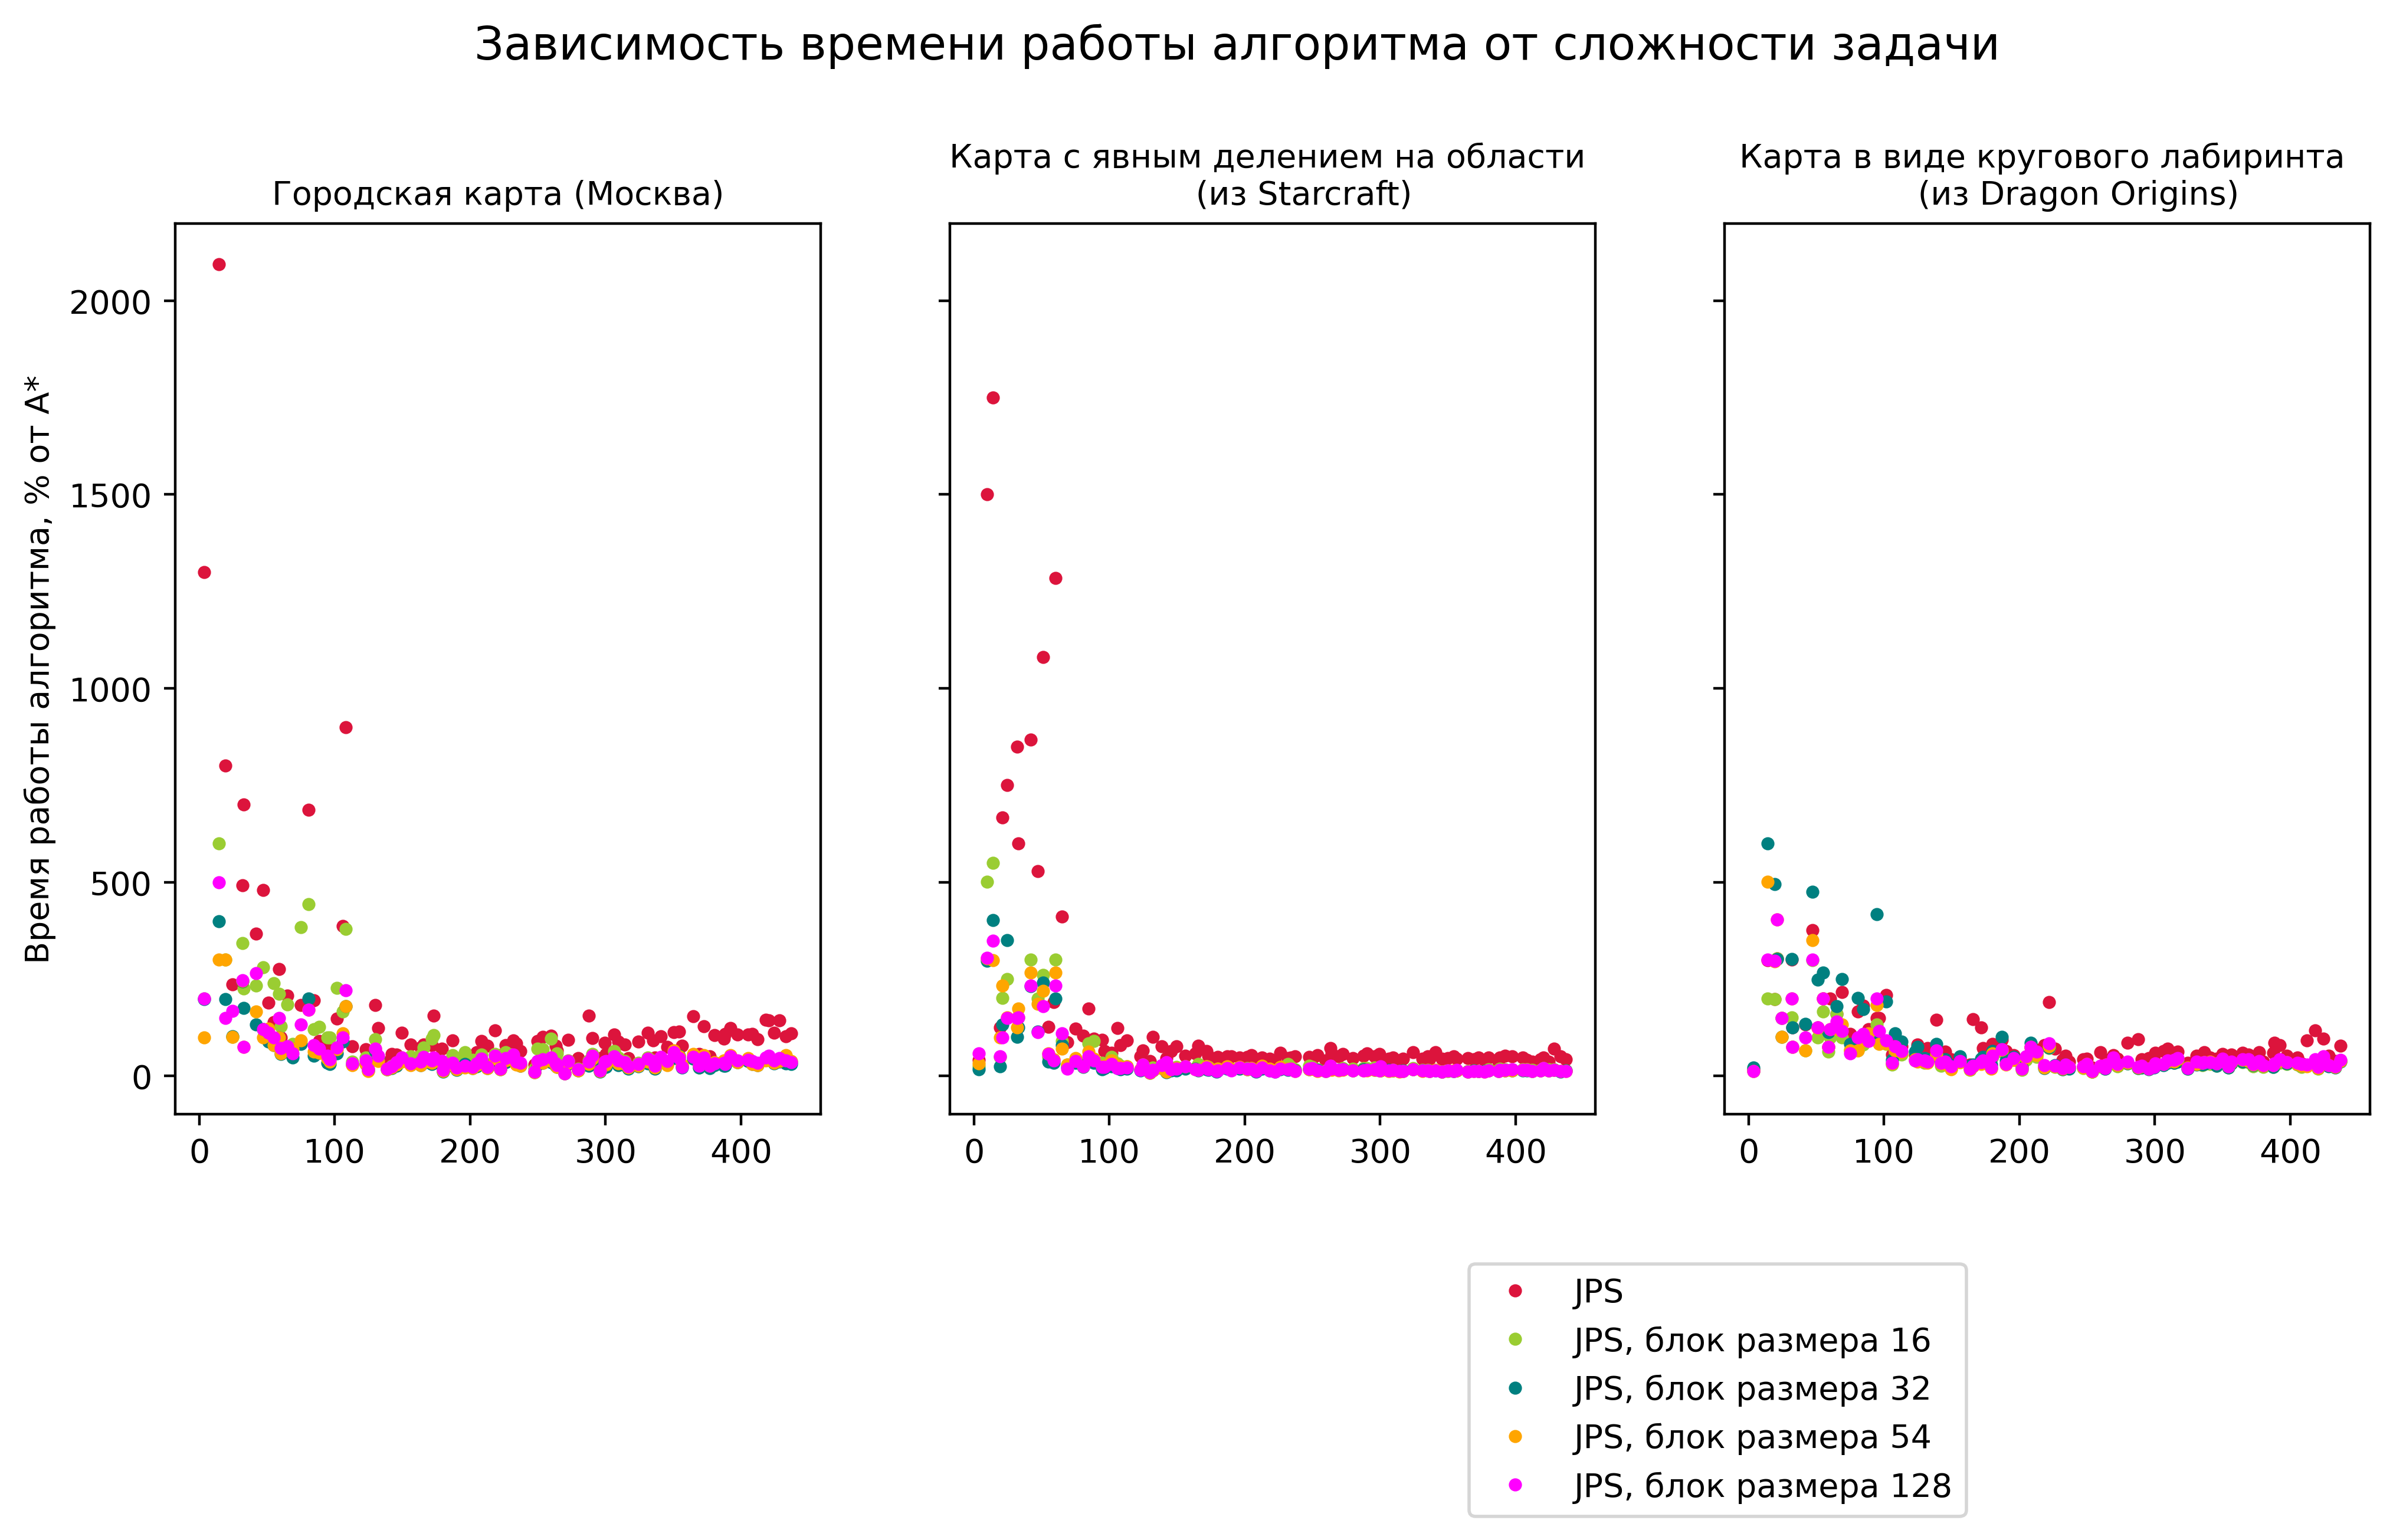

In [481]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 5), dpi=400, sharey=True)
fig.suptitle("Зависимость времени работы алгоритма от сложности задачи", fontsize=14, y=1.05)
ax[0].set_ylabel("Время работы алгоритма, % от A*")


ax[0].set_title('Городская карта (Москва)', fontsize=10)
ax[0].plot(np.sort(moscow_hardness), 
           (JPS_time[0] / A_time[0] * 100)[np.argsort(moscow_hardness)],
            marker='.', color="crimson", linestyle="", label="JPS")
ax[0].plot(np.sort(moscow_hardness), 
           (JPS_block_16_time[0] / A_time[0] * 100)[np.argsort(moscow_hardness)],
            marker='.', color="yellowgreen", linestyle="", label="JPS, блок размера " + str(16))
ax[0].plot(np.sort(moscow_hardness), 
           (JPS_block_32_time[0] / A_time[0] * 100)[np.argsort(moscow_hardness)],
            marker='.', color="teal", linestyle="", label="JPS, блок размера " + str(32))
ax[0].plot(np.sort(moscow_hardness), 
           (JPS_block_64_time[0] / A_time[0] * 100)[np.argsort(moscow_hardness)],
            marker='.', color="orange", linestyle="", label="JPS, блок размера " + str(54))
ax[0].plot(np.sort(moscow_hardness), 
           (JPS_block_128_time[0] / A_time[0] * 100)[np.argsort(moscow_hardness)],
            marker='.', color="magenta", linestyle="", label="JPS, блок размера " + str(128))

ax[1].set_title('Карта с явным делением на области \n      (из Starcraft)', fontsize=10)
ax[1].plot(np.sort(moscow_hardness), 
           (JPS_time[1] / A_time[1] * 100)[np.argsort(moscow_hardness)],
            marker='.', color="crimson", linestyle="", label="JPS")
ax[1].plot(np.sort(moscow_hardness), 
           (JPS_block_16_time[1] / A_time[1] * 100)[np.argsort(moscow_hardness)],
            marker='.', color="yellowgreen", linestyle="", label="JPS, блок размера " + str(16))
ax[1].plot(np.sort(moscow_hardness), 
           (JPS_block_32_time[1] / A_time[1] * 100)[np.argsort(moscow_hardness)],
            marker='.', color="teal", linestyle="", label="JPS, блок размера " + str(32))
ax[1].plot(np.sort(moscow_hardness), 
           (JPS_block_64_time[1] / A_time[1] * 100)[np.argsort(moscow_hardness)],
            marker='.', color="orange", linestyle="", label="JPS, блок размера " + str(54))
ax[1].plot(np.sort(moscow_hardness), 
           (JPS_block_128_time[1] / A_time[1] * 100)[np.argsort(moscow_hardness)],
            marker='.', color="magenta", linestyle="", label="JPS, блок размера " + str(128))

ax[2].set_title('Карта в виде кругового лабиринта \n      (из Dragon Origins)', fontsize=10)
ax[2].plot(np.sort(moscow_hardness), 
           (JPS_time[2] / A_time[2] * 100)[np.argsort(moscow_hardness)],
            marker='.', color="crimson", linestyle="", label="JPS")
ax[2].plot(np.sort(moscow_hardness), 
           (JPS_block_16_time[2] / A_time[2] * 100)[np.argsort(moscow_hardness)],
            marker='.', color="yellowgreen", linestyle="", label="JPS, блок размера " + str(16))
ax[2].plot(np.sort(moscow_hardness), 
           (JPS_block_32_time[2] / A_time[2] * 100)[np.argsort(moscow_hardness)],
            marker='.', color="teal", linestyle="", label="JPS, блок размера " + str(32))
ax[2].plot(np.sort(moscow_hardness), 
           (JPS_block_64_time[2] / A_time[2] * 100)[np.argsort(moscow_hardness)],
            marker='.', color="orange", linestyle="", label="JPS, блок размера " + str(54))
ax[2].plot(np.sort(moscow_hardness), 
           (JPS_block_128_time[2] / A_time[2] * 100)[np.argsort(moscow_hardness)],
            marker='.', color="magenta", linestyle="", label="JPS, блок размера " + str(128))



ax[0].legend(bbox_to_anchor=(2.8, -0.15))
#plt.savefig("boxplot_inliers.png", transparent=False, bbox_inches="tight", facecolor='white')  # сохраняем всю картинку (transparent=False - чтобы фон самой диаграммы не был прозрачен, facecolor='white' - чтобы фон, где надписи был белым а не тусклым, bbox_inches="tight" - чтобы сохранялось все то, что выводится (а не обрезанный кусок))
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_13472\4188313714.py:8: RuntimeWarning: divide by zero encountered in true_divide
  (JPS_time[0] / A_time[0] * 100)[np.argsort(moscow_hardness)],
C:\Users\user\AppData\Local\Temp\ipykernel_13472\4188313714.py:11: RuntimeWarning: divide by zero encountered in true_divide
  (JPS_block_16_time[0] / A_time[0] * 100)[np.argsort(moscow_hardness)],
C:\Users\user\AppData\Local\Temp\ipykernel_13472\4188313714.py:14: RuntimeWarning: divide by zero encountered in true_divide
  (JPS_block_32_time[0] / A_time[0] * 100)[np.argsort(moscow_hardness)],
C:\Users\user\AppData\Local\Temp\ipykernel_13472\4188313714.py:17: RuntimeWarning: divide by zero encountered in true_divide
  (JPS_block_64_time[0] / A_time[0] * 100)[np.argsort(moscow_hardness)],
C:\Users\user\AppData\Local\Temp\ipykernel_13472\4188313714.py:20: RuntimeWarning: divide by zero encountered in true_divide
  (JPS_block_128_time[0] / A_time[0] * 100)[np.argsort(moscow_hardness)],
C:\Users\user\AppDa

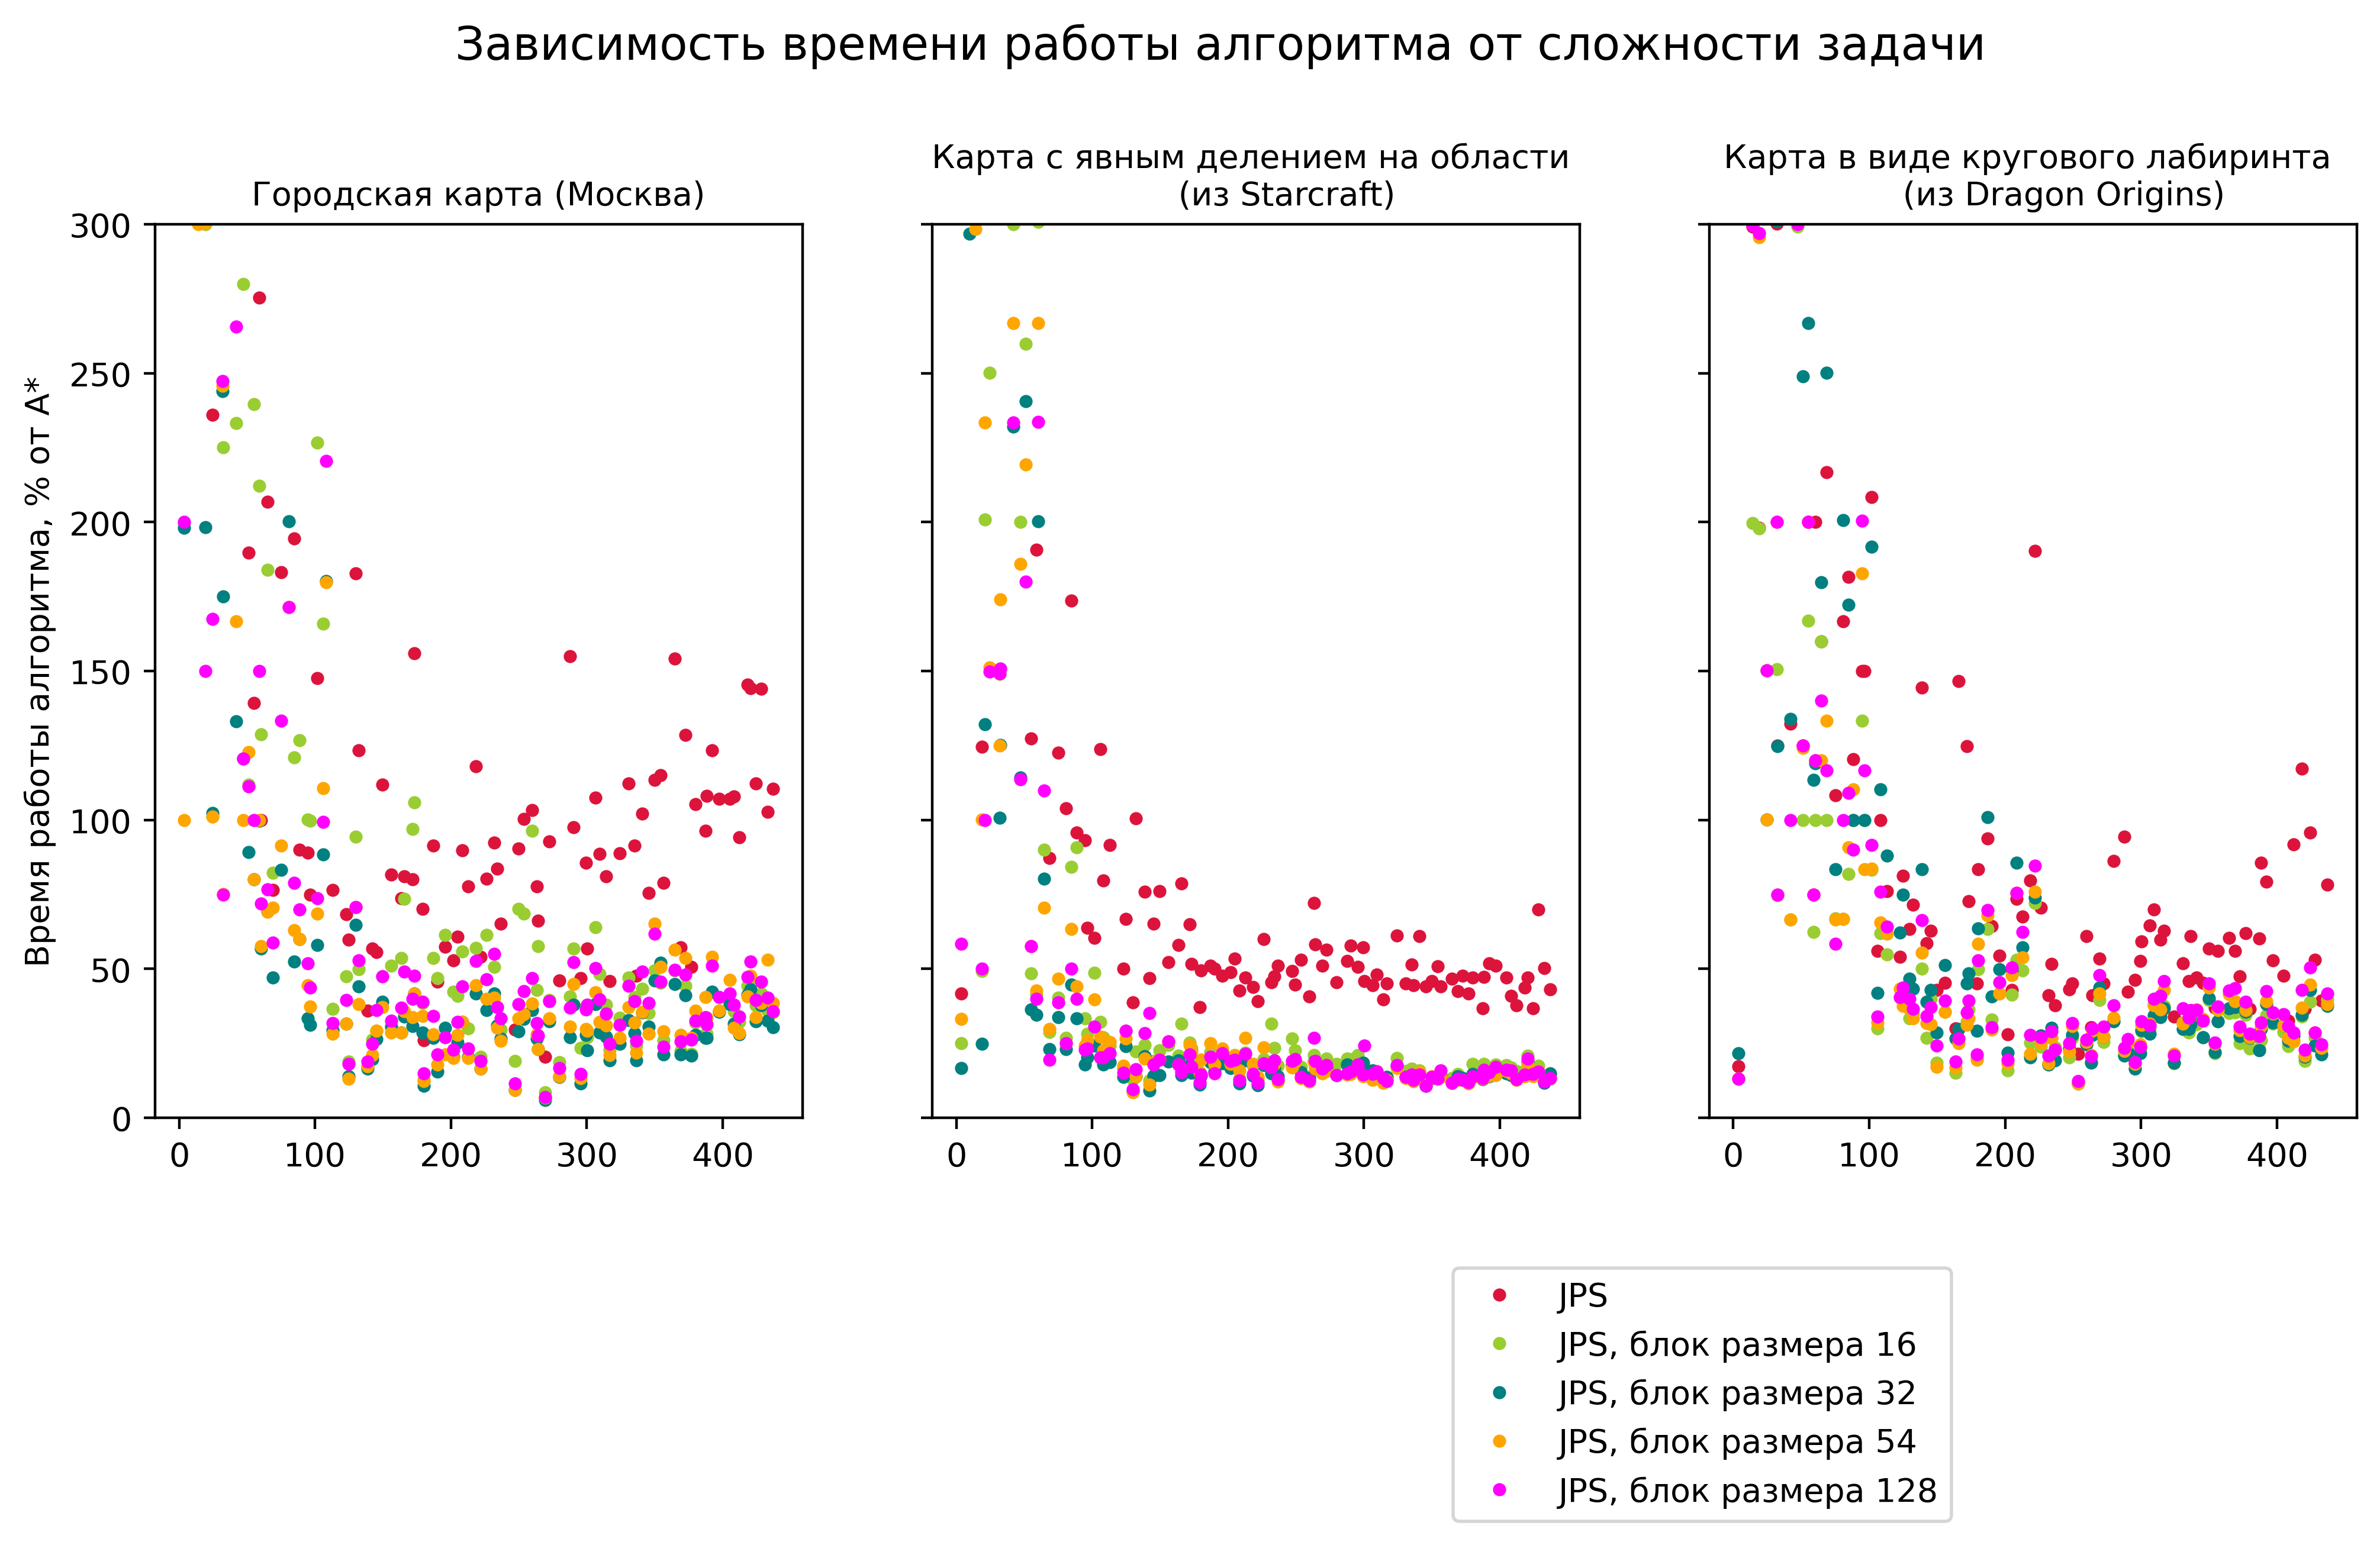

In [483]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 5), dpi=400, sharey=True)
fig.suptitle("Зависимость времени работы алгоритма от сложности задачи", fontsize=14, y=1.05)
ax[0].set_ylabel("Время работы алгоритма, % от A*")


ax[0].set_title('Городская карта (Москва)', fontsize=10)
ax[0].plot(np.sort(moscow_hardness), 
           (JPS_time[0] / A_time[0] * 100)[np.argsort(moscow_hardness)],
            marker='.', color="crimson", linestyle="", label="JPS")
ax[0].plot(np.sort(moscow_hardness), 
           (JPS_block_16_time[0] / A_time[0] * 100)[np.argsort(moscow_hardness)],
            marker='.', color="yellowgreen", linestyle="", label="JPS, блок размера " + str(16))
ax[0].plot(np.sort(moscow_hardness), 
           (JPS_block_32_time[0] / A_time[0] * 100)[np.argsort(moscow_hardness)],
            marker='.', color="teal", linestyle="", label="JPS, блок размера " + str(32))
ax[0].plot(np.sort(moscow_hardness), 
           (JPS_block_64_time[0] / A_time[0] * 100)[np.argsort(moscow_hardness)],
            marker='.', color="orange", linestyle="", label="JPS, блок размера " + str(54))
ax[0].plot(np.sort(moscow_hardness), 
           (JPS_block_128_time[0] / A_time[0] * 100)[np.argsort(moscow_hardness)],
            marker='.', color="magenta", linestyle="", label="JPS, блок размера " + str(128))

ax[1].set_title('Карта с явным делением на области \n      (из Starcraft)', fontsize=10)
ax[1].plot(np.sort(moscow_hardness), 
           (JPS_time[1] / A_time[1] * 100)[np.argsort(moscow_hardness)],
            marker='.', color="crimson", linestyle="", label="JPS")
ax[1].plot(np.sort(moscow_hardness), 
           (JPS_block_16_time[1] / A_time[1] * 100)[np.argsort(moscow_hardness)],
            marker='.', color="yellowgreen", linestyle="", label="JPS, блок размера " + str(16))
ax[1].plot(np.sort(moscow_hardness), 
           (JPS_block_32_time[1] / A_time[1] * 100)[np.argsort(moscow_hardness)],
            marker='.', color="teal", linestyle="", label="JPS, блок размера " + str(32))
ax[1].plot(np.sort(moscow_hardness), 
           (JPS_block_64_time[1] / A_time[1] * 100)[np.argsort(moscow_hardness)],
            marker='.', color="orange", linestyle="", label="JPS, блок размера " + str(54))
ax[1].plot(np.sort(moscow_hardness), 
           (JPS_block_128_time[1] / A_time[1] * 100)[np.argsort(moscow_hardness)],
            marker='.', color="magenta", linestyle="", label="JPS, блок размера " + str(128))

ax[2].set_title('Карта в виде кругового лабиринта \n      (из Dragon Origins)', fontsize=10)
ax[2].plot(np.sort(moscow_hardness), 
           (JPS_time[2] / A_time[2] * 100)[np.argsort(moscow_hardness)],
            marker='.', color="crimson", linestyle="", label="JPS")
ax[2].plot(np.sort(moscow_hardness), 
           (JPS_block_16_time[2] / A_time[2] * 100)[np.argsort(moscow_hardness)],
            marker='.', color="yellowgreen", linestyle="", label="JPS, блок размера " + str(16))
ax[2].plot(np.sort(moscow_hardness), 
           (JPS_block_32_time[2] / A_time[2] * 100)[np.argsort(moscow_hardness)],
            marker='.', color="teal", linestyle="", label="JPS, блок размера " + str(32))
ax[2].plot(np.sort(moscow_hardness), 
           (JPS_block_64_time[2] / A_time[2] * 100)[np.argsort(moscow_hardness)],
            marker='.', color="orange", linestyle="", label="JPS, блок размера " + str(54))
ax[2].plot(np.sort(moscow_hardness), 
           (JPS_block_128_time[2] / A_time[2] * 100)[np.argsort(moscow_hardness)],
            marker='.', color="magenta", linestyle="", label="JPS, блок размера " + str(128))



ax[0].legend(bbox_to_anchor=(2.8, -0.15))
plt.ylim([0, 300])
#plt.savefig("boxplot_inliers.png", transparent=False, bbox_inches="tight", facecolor='white')  # сохраняем всю картинку (transparent=False - чтобы фон самой диаграммы не был прозрачен, facecolor='white' - чтобы фон, где надписи был белым а не тусклым, bbox_inches="tight" - чтобы сохранялось все то, что выводится (а не обрезанный кусок))
plt.show()